In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

In [4]:
# read in data
nov = pd.read_csv('C:\\Users\\chris\\OneDrive\\Grad School\\_ADVANCED MACHINE LEARNING\\Week 3\\Lab\\November Sleep Data - Sheet1.csv')
dec = pd.read_csv('C:\\Users\\chris\\OneDrive\\Grad School\\_ADVANCED MACHINE LEARNING\\Week 3\\Lab\\December Sleep Data - Sheet1.csv')
jan = pd.read_csv('C:\\Users\\chris\\OneDrive\\Grad School\\_ADVANCED MACHINE LEARNING\\Week 3\\Lab\\January Sleep Data - Sheet1.csv')
feb = pd.read_csv('C:\\Users\\chris\\OneDrive\\Grad School\\_ADVANCED MACHINE LEARNING\\Week 3\\Lab\\February Sleep Data - Sheet1.csv')

# add month variables
nov["Month"] = "November"
dec["Month"] = "December"
jan["Month"] = "January"
feb["Month"] = "February"

# rename columns to day of week
nov = nov.rename(columns={"NOVEMBER":"DAY_OF_WEEK"})
dec = dec.rename(columns={"DECEMBER":"DAY_OF_WEEK"})
jan = jan.rename(columns={"JANUARY":"DAY_OF_WEEK"})
feb = feb.rename(columns={"FEBRUARY":"DAY_OF_WEEK"})


In [6]:
# combine all data
df = pd.concat([nov,dec,jan,feb])
df.head()

,DAY_OF_WEEK,DATE,SLEEP_SCORE,HOURS_OF_SLEEP,REM_SLEEP,DEEP_SLEEP,HEART_RATE_BELOW_RESTING,SLEEP_TIME,Month
0,Monday,11/1/2021,88,8:06:00,20.00%,13.00%,84.00%,10:41pm - 7:54am,November
1,Tuesday,11/2/2021,83,7:57:00,12.00%,18.00%,90.00%,10:40pm - 7:55am,November
2,Wednesday,11/3/2021,81,7:06:00,13.00%,22.00%,93.00%,11:03pm - 7:16am,November
3,Thursday,11/4/2021,86,7:04:00,19.00%,17.00%,97.00%,10:55pm - 6:56am,November
4,Friday,11/5/2021,81,9:24:00,17.00%,15.00%,66.00%,10:14pm - 9:01am,November


In [8]:
# create new column "HOURS" for hours of sleep
df['HOURS'] = df.HOURS_OF_SLEEP.apply(lambda x: x[:x.find(":")])
df["HOURS"] = pd.to_numeric(df["HOURS"])

# create new column "MINS"
df['MINS'] = df.HOURS_OF_SLEEP.apply(lambda x: x[x.find(":") + 1: x.find(":") + 3])
df["MINS"] = pd.to_numeric(df["MINS"])

# calculate total minutes of sleep
df["TOTAL_MINS"] = df['HOURS'] * 60 + df['MINS']

In [9]:
# new column for what hour person fell asleep at
df['FELL_ASLEEP'] = df.SLEEP_TIME.apply(lambda x: x[:2])
pd.set_option('display.max_rows', None)
df['FELL_ASLEEP'] = df['FELL_ASLEEP'].str.rstrip(':').astype('float')

# categorical variable. If they fell asleep at 9 or 10 column = 1, else column = 0
df['FELL_ASLEEP_EARLY'] = np.where((df['FELL_ASLEEP']== 10) | (df['FELL_ASLEEP']== 9), 1, 0)

In [10]:
# change data types of columns
df['DEEP_SLEEP'] = df['DEEP_SLEEP'].str.rstrip('%').astype('float')
df['REM_SLEEP'] = df['REM_SLEEP'].str.rstrip('%').astype('float')
df['HEART_RATE_BELOW_RESTING'] = df['HEART_RATE_BELOW_RESTING'].str.rstrip('%').astype('float')

DAY_OF_WEEK                  object
DATE                         object
SLEEP_SCORE                   int64
HOURS_OF_SLEEP               object
REM_SLEEP                   float64
DEEP_SLEEP                  float64
HEART_RATE_BELOW_RESTING    float64
SLEEP_TIME                   object
Month                        object
HOURS                         int64
MINS                          int64
TOTAL_MINS                    int64
FELL_ASLEEP                 float64
FELL_ASLEEP_EARLY             int32
dtype: object

In [11]:
# drop unneeded columns
df = df.drop(['DATE', 'HOURS_OF_SLEEP','SLEEP_TIME', 'HOURS', 'MINS','FELL_ASLEEP'], axis = 1)

In [12]:
# Binary encode categorical variables
df = pd.get_dummies(df, prefix=['DAY_OF_WEEK', 'Month'])

In [13]:
# Split Predictor vs Target variables
X = df.loc[:, df.columns != 'SLEEP_SCORE']
y = df.loc[:, df.columns == 'SLEEP_SCORE']
X.head()

,REM_SLEEP,DEEP_SLEEP,HEART_RATE_BELOW_RESTING,TOTAL_MINS,FELL_ASLEEP_EARLY,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,Month_December,Month_February,Month_January,Month_November
0,20.0,13.0,84.0,486,1,0,1,0,0,0,0,0,0,0,0,1
1,12.0,18.0,90.0,477,1,0,0,0,0,0,1,0,0,0,0,1
2,13.0,22.0,93.0,426,0,0,0,0,0,0,0,1,0,0,0,1
3,19.0,17.0,97.0,424,1,0,0,0,0,1,0,0,0,0,0,1
4,17.0,15.0,66.0,564,1,1,0,0,0,0,0,0,0,0,0,1


In [14]:
# scale variables
from sklearn.preprocessing import StandardScaler

# Scale predictor variables
scaled_features = StandardScaler().fit_transform(X.values)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)


In [16]:
# scale y variables
scaled_y = StandardScaler().fit_transform(y.values)
scaled_y_df = pd.DataFrame(scaled_y, index=y.index, columns=y.columns)

In [17]:
y = scaled_y_df
X = scaled_features_df

### Stacking Model 1

In [18]:
estimators = [
     ('lr', RidgeCV()),
     ('svr', LinearSVR(random_state=42)),
     ('cart', DecisionTreeRegressor()),
     ('rf', RandomForestRegressor(min_samples_split = 25))
 ]

reg = StackingRegressor(
     estimators=estimators,
     final_estimator=LinearRegression()
)

In [19]:
# split into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, random_state=42)

r_sq = reg.fit(X_train, y_train).score(X_test, y_test)
print('R-squared: ' + str(round(r_sq,3)))

R-squared: 0.774


### Stacking Model 2

In [20]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(min_samples_split = 25)))
    level0.append(('svm', SVR()))
    level0.append(('lr', LinearRegression()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [21]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor()
    models['cart'] = DecisionTreeRegressor()
    models['svm'] = SVR()
    models['lr'] = LinearRegression()
    models['stacking'] = get_stacking()
    return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>knn 0.202 (0.236)
>cart 0.637 (0.196)
>svm 0.552 (0.172)
>lr 0.718 (0.218)
>stacking 0.749 (0.180)


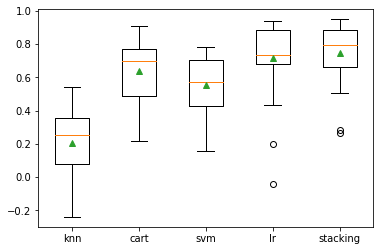

In [22]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Bagging Model 1 - Decision Tree

In [23]:
from sklearn.ensemble import BaggingRegressor
# define the model
model = BaggingRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('R-squared: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R-squared: 0.779 (0.107)


### Bagging Model 2 - Random Forest

In [24]:
from sklearn.ensemble import BaggingRegressor
# define the model
model = BaggingRegressor(base_estimator = RandomForestRegressor())
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('R-squared: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R-squared: 0.776 (0.088)


### Bagging Model 3 - Linear Regression

In [25]:
from sklearn.ensemble import BaggingRegressor
# define the model
model = BaggingRegressor(base_estimator = LinearRegression())
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('R-squared: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R-squared: 0.719 (0.214)


The best model according to r-squared is the decision tree bagging model. Given an r-squared of 0.779 we have a good idea of what sleep score FitBit will output. However, there's still much to be improved on by the model. 